In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'brk'
model_name = 'distilbert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5778016724756786 	 Validation loss: 0.40420756148079695 	 
  1%|          | 574/57400 [03:28<5:38:57,  2.79it/s]
Epoch 2 	 Training loss: 0.38603766220994945 	 Validation loss: 0.3556470527487286 	 
  2%|▏         | 1148/57400 [06:56<5:48:42,  2.69it/s]
Epoch 3 	 Training loss: 0.3535904266485354 	 Validation loss: 0.3389888628054473 	 
  3%|▎         | 1722/57400 [09:53<4:59:35,  3.10it/s]
Epoch 4 	 Training loss: 0.3343853326417012 	 Validation loss: 0.33013561822600285 	 
  4%|▍         | 2296/57400 [12:43<4:26:19,  3.45it/s]
Epoch 5 	 Training loss: 0.32219355766262325 	 Validation loss: 0.3226595985687385 	 
  5%|▌         | 2870/57400 [15:38<4:48:20,  3.15it/s]
Epoch 6 	 Training loss: 0.31099853184372706 	 Validation loss: 0.31784399106340894 	 
  6%|▌         | 3444/57400 [19:00<5:16:19,  2.84it/s]
Epoch 7 	 Training loss: 0.301366611095048 	 Validation loss: 0.3135618936207335 	 
  7%|▋         | 4018/57400 [22:28<4:20:52,  3.41it/s]
Epoch 8 	 Traini

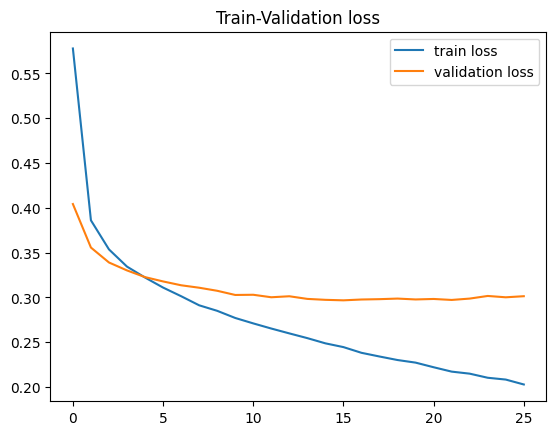

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8225, 'male': 0.8541666666666666, 'average': 0.8383333333333334}
precision {'female': 0.8545454545454545, 'male': 0.8220551378446115, 'average': 0.838300296195033}
f1 {'female': 0.8382165605095542, 'male': 0.8378033205619412, 'average': 0.8380099405357477}
accuracy 0.8380102040816326


Evaluación en el conjunto el conjunto to
recall {'female': 0.6377952755905512, 'male': 0.6885644768856448, 'average': 0.663179876238098}
precision {'female': 0.6549865229110512, 'male': 0.672209026128266, 'average': 0.6635977745196586}
f1 {'female': 0.6462765957446808, 'male': 0.6802884615384615, 'average': 0.6632825286415711}
accuracy 0.6641414141414141


Evaluación en el conjunto el conjunto as
recall {'female': 0.6738544474393531, 'male': 0.6767676767676768, 'average': 0.675311062103515}
precision {'female': 0.6613756613756614, 'male': 0.6889460154241646, 'average': 0.675160838399913}
f1 {'female': 0.6675567423230975, 'male': 0.68280254

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6332216805385795 	 Validation loss: 0.44987598162586406 	 
  1%|          | 574/57400 [02:25<4:24:24,  3.58it/s]
Epoch 2 	 Training loss: 0.4021309491649322 	 Validation loss: 0.358359241889695 	 
  2%|▏         | 1148/57400 [04:51<3:53:45,  4.01it/s]
Epoch 3 	 Training loss: 0.3582102939590344 	 Validation loss: 0.3407559149851233 	 
  3%|▎         | 1722/57400 [07:16<4:05:57,  3.77it/s]
Epoch 4 	 Training loss: 0.3374518867621023 	 Validation loss: 0.3310768038539563 	 
  4%|▍         | 2296/57400 [09:42<3:43:50,  4.10it/s]
Epoch 5 	 Training loss: 0.3245772872029281 	 Validation loss: 0.3249615999096531 	 
  5%|▌         | 2870/57400 [12:07<3:02:14,  4.99it/s]
Epoch 6 	 Training loss: 0.31224895954028237 	 Validation loss: 0.31919745469497424 	 
  6%|▌         | 3444/57400 [14:33<3:53:41,  3.85it/s]
Epoch 7 	 Training loss: 0.30318293107822797 	 Validation loss: 0.3160265242144213 	 
  7%|▋         | 4018/57400 [16:58<3:38:03,  4.08it/s]
Epoch 8 	 Training

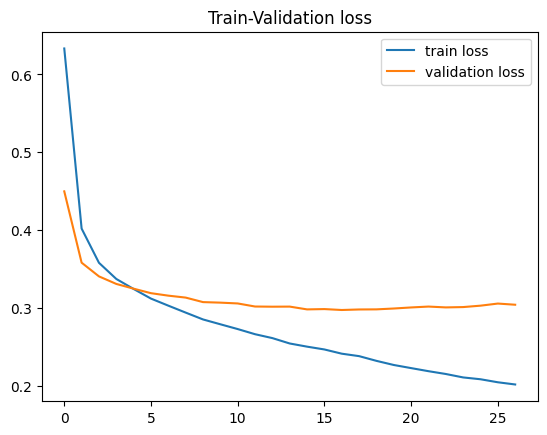

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p =train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.835, 'male': 0.8333333333333334, 'average': 0.8341666666666667}
precision {'female': 0.8391959798994975, 'male': 0.8290155440414507, 'average': 0.8341057619704741}
f1 {'female': 0.8370927318295739, 'male': 0.8311688311688311, 'average': 0.8341307814992025}
accuracy 0.8341836734693877


Evaluación en el conjunto el conjunto to
recall {'female': 0.6377952755905512, 'male': 0.681265206812652, 'average': 0.6595302412016015}
precision {'female': 0.6497326203208557, 'male': 0.6698564593301436, 'average': 0.6597945398254996}
f1 {'female': 0.6437086092715233, 'male': 0.6755126658624849, 'average': 0.6596106375670041}
accuracy 0.6603535353535354


Evaluación en el conjunto el conjunto as
recall {'female': 0.6981132075471698, 'male': 0.648989898989899, 'average': 0.6735515532685343}
precision {'female': 0.6507537688442211, 'male': 0.6964769647696477, 'average': 0.6736153668069345}
f1 {'female': 0.6736020806241871, 'male': 0.671895

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5877427402169862 	 Validation loss: 0.42915103799205717 	 
  1%|          | 574/57400 [02:25<3:56:35,  4.00it/s]
Epoch 2 	 Training loss: 0.4036032469741974 	 Validation loss: 0.36452713356179706 	 
  2%|▏         | 1148/57400 [04:50<3:59:22,  3.92it/s]
Epoch 3 	 Training loss: 0.36116551870045344 	 Validation loss: 0.3445221983780295 	 
  3%|▎         | 1722/57400 [07:16<3:52:49,  3.99it/s]
Epoch 4 	 Training loss: 0.3406105860548568 	 Validation loss: 0.3334563220456495 	 
  4%|▍         | 2296/57400 [09:42<3:39:37,  4.18it/s]
Epoch 5 	 Training loss: 0.32720623757261846 	 Validation loss: 0.32735870197667916 	 
  5%|▌         | 2870/57400 [12:07<3:04:19,  4.93it/s]
Epoch 6 	 Training loss: 0.31554232924553577 	 Validation loss: 0.3210404808238401 	 
  6%|▌         | 3444/57400 [14:33<3:40:18,  4.08it/s]
Epoch 7 	 Training loss: 0.30516581408653526 	 Validation loss: 0.31768018815477017 	 
  7%|▋         | 4018/57400 [16:58<2:58:21,  4.99it/s]
Epoch 8 	 Tra

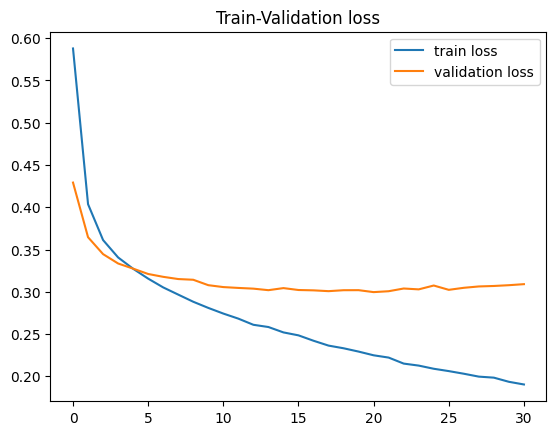

In [21]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [22]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8475, 'male': 0.8411458333333334, 'average': 0.8443229166666667}
precision {'female': 0.8475, 'male': 0.8411458333333334, 'average': 0.8443229166666667}
f1 {'female': 0.8475, 'male': 0.8411458333333333, 'average': 0.8443229166666666}
accuracy 0.8443877551020408


Evaluación en el conjunto el conjunto to
recall {'female': 0.6561679790026247, 'male': 0.6885644768856448, 'average': 0.6723662279441347}
precision {'female': 0.6613756613756614, 'male': 0.6835748792270532, 'average': 0.6724752703013572}
f1 {'female': 0.6587615283267457, 'male': 0.6860606060606061, 'average': 0.6724110671936759}
accuracy 0.672979797979798


Evaluación en el conjunto el conjunto as
recall {'female': 0.7277628032345014, 'male': 0.6565656565656566, 'average': 0.692164229900079}
precision {'female': 0.6650246305418719, 'male': 0.7202216066481995, 'average': 0.6926231185950357}
f1 {'female': 0.694980694980695, 'male': 0.6869220607661822, 'average': 0

Resultados finales

In [23]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8388212129005389
f1 etiqueta male: 0.8367059950213686
f1 etiqueta female:  0.8409364307797094


TO
Resultado global f1: 0.6651014111340837
f1 etiqueta male: 0.6806205778205175
f1 etiqueta female:  0.6495822444476499


AS
Resultado global f1: 0.6796265918835773
f1 etiqueta male: 0.6805400111244948
f1 etiqueta female:  0.6787131726426598


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8389409722222223
recall etiqueta male: 0.8428819444444444
recall etiqueta female:  0.835


TO
Resultado global recall: 0.6650254484612781
recall etiqueta male: 0.6861313868613139
recall etiqueta female:  0.6439195100612424


AS
Resultado global recall: 0.6803422817573761
recall etiqueta male: 0.6607744107744108
recall etiqueta female:  0.6999101527403414


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8389096582773913
precision etiqueta male: 0.8307388384064652
precision etiqueta female:  0.84708047814831

# TO

In [25]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [26]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.696491762632277 	 Validation loss: 0.6942421601990522 	 
  1%|          | 574/57400 [02:17<3:45:32,  4.20it/s]
Epoch 2 	 Training loss: 0.6960433266719459 	 Validation loss: 0.6925079590183193 	 
  2%|▏         | 1148/57400 [04:34<3:42:48,  4.21it/s]
Epoch 3 	 Training loss: 0.6956194142846696 	 Validation loss: 0.6926997950521566 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [06:50<3:35:24,  4.31it/s]
Epoch 4 	 Training loss: 0.6952561364356649 	 Validation loss: 0.6930249767788386 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [09:07<3:46:33,  4.05it/s]
Epoch 5 	 Training loss: 0.6951306814308366 	 Validation loss: 0.6934083831512322 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [11:24<3:36:28,  4.20it/s]
Epoch 6 	 Training loss: 0.6946586801407645 	 Validation loss: 0.6939660613819704 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [13:40<3:30:21,  4.27it/s]
Epoch 7 	 Training loss: 0.6945621184355706 	 

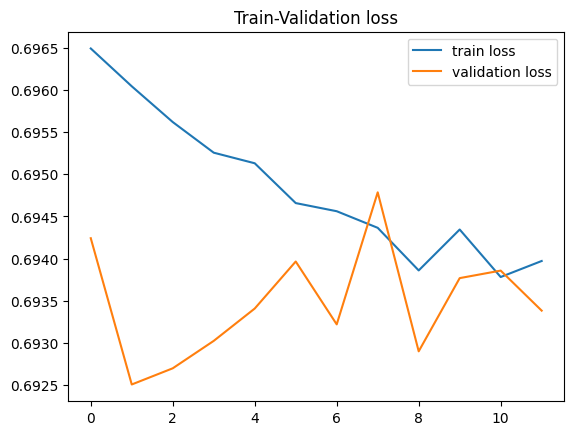

In [27]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.425, 'male': 0.5911458333333334, 'average': 0.5080729166666667}
precision {'female': 0.5198776758409785, 'male': 0.49671772428884026, 'average': 0.5082977000649094}
f1 {'female': 0.46767537826685, 'male': 0.539833531510107, 'average': 0.5037544548884785}
accuracy 0.5063775510204082


Evaluación en el conjunto el conjunto to
recall {'female': 0.4461942257217848, 'male': 0.6155717761557178, 'average': 0.5308830009387513}
precision {'female': 0.5182926829268293, 'male': 0.5452586206896551, 'average': 0.5317756518082422}
f1 {'female': 0.47954866008462627, 'male': 0.5782857142857144, 'average': 0.5289171871851703}
accuracy 0.5340909090909091


Evaluación en el conjunto el conjunto as
recall {'female': 0.4420485175202156, 'male': 0.6338383838383839, 'average': 0.5379434506792997}
precision {'female': 0.5307443365695793, 'male': 0.5480349344978166, 'average': 0.539389635533698}
f1 {'female': 0.48235294117647054, 'male': 0.58782

In [29]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955067439569413 	 Validation loss: 0.6928116376117125 	 
  1%|          | 574/57400 [02:51<4:39:06,  3.39it/s]
Epoch 2 	 Training loss: 0.6941317781961753 	 Validation loss: 0.6949317829083588 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [05:42<5:29:17,  2.85it/s]
Epoch 3 	 Training loss: 0.6934476705586038 	 Validation loss: 0.6925686809976223 	 
  3%|▎         | 1722/57400 [08:32<3:33:30,  4.35it/s]
Epoch 4 	 Training loss: 0.69326032028381 	 Validation loss: 0.6928842037411059 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [11:23<3:29:36,  4.38it/s]
Epoch 5 	 Training loss: 0.6933174034651979 	 Validation loss: 0.692229118387578 	 
  5%|▌         | 2870/57400 [14:13<4:24:17,  3.44it/s]
Epoch 6 	 Training loss: 0.6934144583105626 	 Validation loss: 0.6932881979619042 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [17:04<4:37:36,  3.24it/s]
Epoch 7 	 Training loss: 0.6931016134675787 	 Validation loss: 0.693419812089

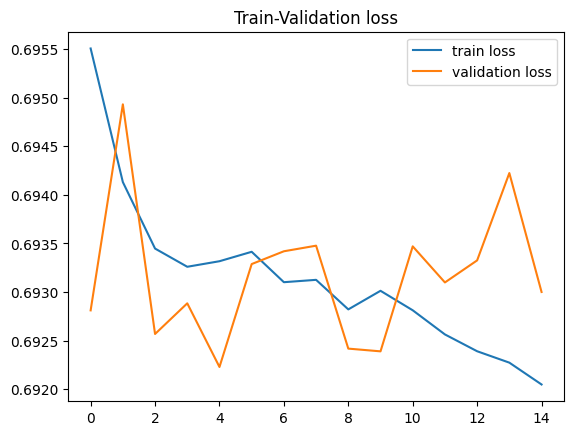

In [30]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [31]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.7725, 'male': 0.3333333333333333, 'average': 0.5529166666666666}
precision {'female': 0.5469026548672566, 'male': 0.5844748858447488, 'average': 0.5656887703560027}
f1 {'female': 0.6404145077720207, 'male': 0.42454394693200664, 'average': 0.5324792273520137}
accuracy 0.5573979591836735


Evaluación en el conjunto el conjunto to
recall {'female': 0.6981627296587927, 'male': 0.39902676399026765, 'average': 0.5485947468245301}
precision {'female': 0.5185185185185185, 'male': 0.5878136200716846, 'average': 0.5531660692951015}
f1 {'female': 0.5950782997762865, 'male': 0.4753623188405798, 'average': 0.5352203093084331}
accuracy 0.5429292929292929


Evaluación en el conjunto el conjunto as
recall {'female': 0.7520215633423181, 'male': 0.2878787878787879, 'average': 0.519950175610553}
precision {'female': 0.49732620320855614, 'male': 0.5533980582524272, 'average': 0.5253621307304916}
f1 {'female': 0.5987124463519314, 'male': 0.3

In [32]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6962033086537484 	 Validation loss: 0.6919235859887075 	 
  1%|          | 574/57400 [02:26<4:02:33,  3.90it/s]
Epoch 2 	 Training loss: 0.6952312565846726 	 Validation loss: 0.6920756404682741 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:53<3:42:37,  4.21it/s]
Epoch 3 	 Training loss: 0.6942267787581121 	 Validation loss: 0.6932494468608145 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:20<3:43:04,  4.16it/s]
Epoch 4 	 Training loss: 0.6942035523648876 	 Validation loss: 0.6912180134805582 	 
  4%|▍         | 2296/57400 [09:47<3:56:55,  3.88it/s]
Epoch 5 	 Training loss: 0.6939184603375425 	 Validation loss: 0.6949118971824646 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [12:14<3:46:40,  4.01it/s]
Epoch 6 	 Training loss: 0.6938240732673153 	 Validation loss: 0.692980235916073 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [14:41<3:47:24,  3.95it/s]
Epoch 7 	 Training loss: 0.693687918398023 	 V

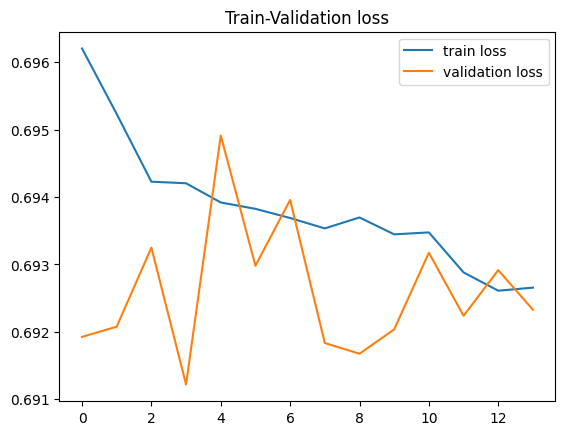

In [33]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8675, 'male': 0.2109375, 'average': 0.5392187500000001}
precision {'female': 0.5338461538461539, 'male': 0.6044776119402985, 'average': 0.5691618828932261}
f1 {'female': 0.6609523809523811, 'male': 0.3127413127413128, 'average': 0.4868468468468469}
accuracy 0.5459183673469388


Evaluación en el conjunto el conjunto to
recall {'female': 0.863517060367454, 'male': 0.14841849148418493, 'average': 0.5059677759258194}
precision {'female': 0.4845360824742268, 'male': 0.5398230088495575, 'average': 0.5121795456618922}
f1 {'female': 0.620754716981132, 'male': 0.23282442748091603, 'average': 0.42678957223102404}
accuracy 0.49242424242424243


Evaluación en el conjunto el conjunto as
recall {'female': 0.9056603773584906, 'male': 0.15151515151515152, 'average': 0.5285877644368211}
precision {'female': 0.5, 'male': 0.631578947368421, 'average': 0.5657894736842105}
f1 {'female': 0.6442953020134228, 'male': 0.2443991853360489, 'averag

Resultados finales

In [35]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5076935096957798
f1 etiqueta male: 0.42570626372780884
f1 etiqueta female:  0.5896807556637506


TO
Resultado global f1: 0.4969756895748758
f1 etiqueta male: 0.4288241535357367
f1 etiqueta female:  0.565127225614015


AS
Resultado global f1: 0.4893865717429392
f1 etiqueta male: 0.40365291363860345
f1 etiqueta female:  0.575120229847275


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5076935096957798
recall etiqueta male: 0.42570626372780884
recall etiqueta female:  0.5896807556637506


TO
Resultado global recall: 0.4969756895748758
recall etiqueta male: 0.4288241535357367
recall etiqueta female:  0.565127225614015


AS
Resultado global recall: 0.4893865717429392
recall etiqueta male: 0.40365291363860345
recall etiqueta female:  0.575120229847275


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5076935096957798
precision etiqueta male: 0.42570626372780884
precision etiqueta female:  0.

# AS

In [36]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [37]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6979409555940262 	 Validation loss: 0.6924235184313887 	 
  1%|          | 574/57400 [02:27<3:12:15,  4.93it/s]
Epoch 2 	 Training loss: 0.6968362556725014 	 Validation loss: 0.6935241919452861 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:54<3:53:27,  4.02it/s]
Epoch 3 	 Training loss: 0.6956136934848612 	 Validation loss: 0.6926992414361339 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:21<3:53:41,  3.97it/s]
Epoch 4 	 Training loss: 0.6942053676066914 	 Validation loss: 0.6916418307918614 	 
  4%|▍         | 2296/57400 [09:48<3:42:40,  4.12it/s]
Epoch 5 	 Training loss: 0.6932922949566659 	 Validation loss: 0.6927717297764148 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [12:14<3:57:12,  3.83it/s]
Epoch 6 	 Training loss: 0.6918686011527058 	 Validation loss: 0.6921196438498416 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [14:41<3:49:08,  3.92it/s]
Epoch 7 	 Training loss: 0.6907171352607447 	

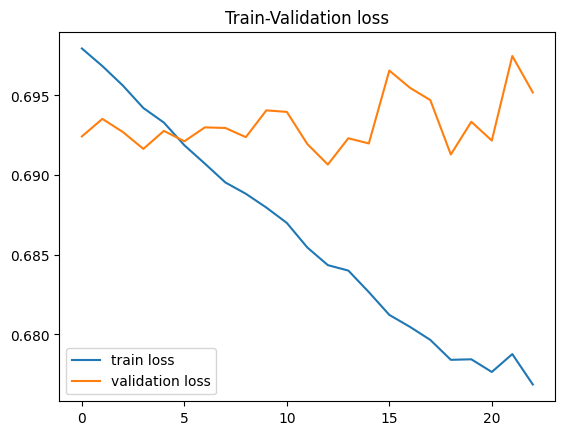

In [38]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [39]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.635, 'male': 0.65625, 'average': 0.645625}
precision {'female': 0.6580310880829016, 'male': 0.6331658291457286, 'average': 0.6455984586143151}
f1 {'female': 0.6463104325699746, 'male': 0.6445012787723786, 'average': 0.6454058556711766}
accuracy 0.6454081632653061


Evaluación en el conjunto el conjunto to
recall {'female': 0.6220472440944882, 'male': 0.7007299270072993, 'average': 0.6613885855508937}
precision {'female': 0.6583333333333333, 'male': 0.6666666666666666, 'average': 0.6625}
f1 {'female': 0.6396761133603238, 'male': 0.6832740213523132, 'average': 0.6614750673563186}
accuracy 0.6628787878787878


Evaluación en el conjunto el conjunto as
recall {'female': 0.7277628032345014, 'male': 0.6590909090909091, 'average': 0.6934268561627053}
precision {'female': 0.6666666666666666, 'male': 0.7209944751381215, 'average': 0.6938305709023941}
f1 {'female': 0.6958762886597939, 'male': 0.6886543535620052, 'average': 0.692265

In [40]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6954343804914361 	 Validation loss: 0.6918259687342886 	 
  1%|          | 574/57400 [02:27<3:52:50,  4.07it/s]
Epoch 2 	 Training loss: 0.6933175357584339 	 Validation loss: 0.6921501331410166 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:54<3:51:18,  4.05it/s]
Epoch 3 	 Training loss: 0.6921653501455792 	 Validation loss: 0.6922638911311909 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:21<3:59:16,  3.88it/s]
Epoch 4 	 Training loss: 0.6909228090832873 	 Validation loss: 0.6930110373739469 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [09:48<3:44:07,  4.10it/s]
Epoch 5 	 Training loss: 0.6899055182310763 	 Validation loss: 0.6906678787732529 	 
  5%|▌         | 2870/57400 [12:15<3:11:02,  4.76it/s]
Epoch 6 	 Training loss: 0.6883628382915403 	 Validation loss: 0.6925335970975585 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [14:42<3:36:29,  4.15it/s]
Epoch 7 	 Training loss: 0.6874673330202336 	

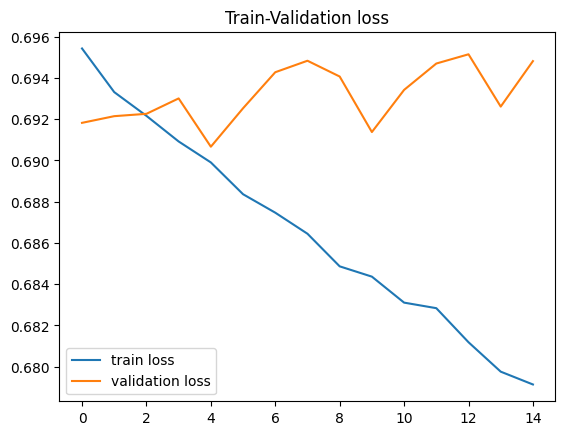

In [41]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [42]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6975, 'male': 0.3880208333333333, 'average': 0.5427604166666666}
precision {'female': 0.5428015564202334, 'male': 0.5518518518518518, 'average': 0.5473267041360426}
f1 {'female': 0.610503282275711, 'male': 0.45565749235474007, 'average': 0.5330803873152256}
accuracy 0.5459183673469388


Evaluación en el conjunto el conjunto to
recall {'female': 0.6981627296587927, 'male': 0.4233576642335766, 'average': 0.5607601969461846}
precision {'female': 0.5288270377733598, 'male': 0.6020761245674741, 'average': 0.5654515811704169}
f1 {'female': 0.6018099547511312, 'male': 0.4971428571428571, 'average': 0.5494764059469941}
accuracy 0.5555555555555556


Evaluación en el conjunto el conjunto as
recall {'female': 0.7547169811320755, 'male': 0.38636363636363635, 'average': 0.570540308747856}
precision {'female': 0.5353728489483748, 'male': 0.6270491803278688, 'average': 0.5812110146381217}
f1 {'female': 0.6263982102908279, 'male': 0.478

In [43]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7116352093344366 	 Validation loss: 0.7031942828226898 	 
  1%|          | 574/57400 [02:27<3:55:24,  4.02it/s]
Epoch 2 	 Training loss: 0.7115038050799419 	 Validation loss: 0.7018005191269567 	 
  2%|▏         | 1148/57400 [04:54<4:03:17,  3.85it/s]
Epoch 3 	 Training loss: 0.7110616583442023 	 Validation loss: 0.7035602209931713 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [07:22<3:57:07,  3.91it/s]
Epoch 4 	 Training loss: 0.7130535178483571 	 Validation loss: 0.7025909060138767 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [09:48<3:09:24,  4.85it/s]
Epoch 5 	 Training loss: 0.7118186058690739 	 Validation loss: 0.7035053998737012 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [12:16<3:51:22,  3.93it/s]
Epoch 6 	 Training loss: 0.7119499974549856 	 Validation loss: 0.7035757272930468 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [14:43<2:57:44,  5.06it/s]
Epoch 7 	 Training loss: 0.71198817371076 	 V

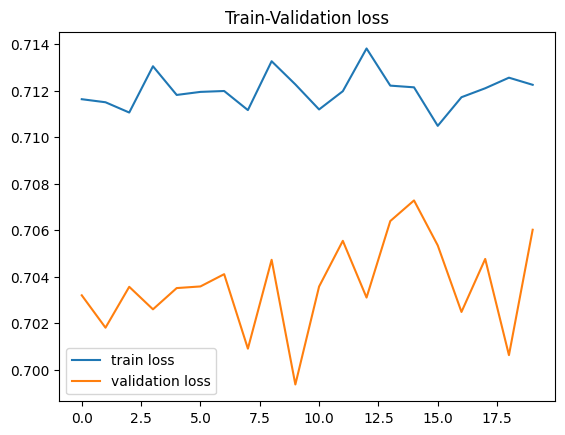

In [44]:
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [45]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about


c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.5102040816326531, 'male': 0.0, 'average': 0.25510204081632654}
f1 {'female': 0.6756756756756758, 'male': 0.0, 'average': 0.3378378378378379}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to


c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.4810606060606061, 'male': 0.0, 'average': 0.24053030303030304}
f1 {'female': 0.6496163682864451, 'male': 0.0, 'average': 0.32480818414322254}
accuracy 0.4810606060606061


Evaluación en el conjunto el conjunto as
recall {'female': 1.0, 'male': 0.0, 'average': 0.5}
precision {'female': 0.48370273794002605, 'male': 0.0, 'average': 0.24185136897001303}
f1 {'female': 0.6520210896309314, 'male': 0.0, 'average': 0.3260105448154657}
accuracy 0.48370273794002605


c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resultados finales

In [46]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5054413602747467
f1 etiqueta male: 0.36671959037570623
f1 etiqueta female:  0.6441631301737871


TO
Resultado global f1: 0.5119198858155117
f1 etiqueta male: 0.3934722928317234
f1 etiqueta female:  0.6303674787993


AS
Resultado global f1: 0.5235124903572597
f1 etiqueta male: 0.38892645118733504
f1 etiqueta female:  0.6580985295271844


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5054413602747467
recall etiqueta male: 0.36671959037570623
recall etiqueta female:  0.6441631301737871


TO
Resultado global recall: 0.5119198858155117
recall etiqueta male: 0.3934722928317234
recall etiqueta female:  0.6303674787993


AS
Resultado global recall: 0.5235124903572597
recall etiqueta male: 0.38892645118733504
recall etiqueta female:  0.6580985295271844


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5054413602747467
precision etiqueta male: 0.36671959037570623
precision etiqueta female:  0.64